Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


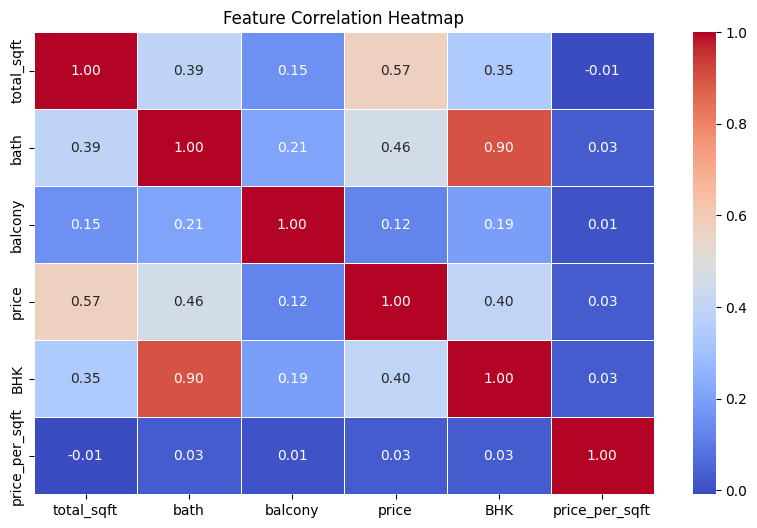

Mean Absolute Error: 45.69796364095838
Mean Squared Error: 9770.154620322015
Root Mean Squared Error: 98.84409249076049
R² Score: 0.4496280475974249


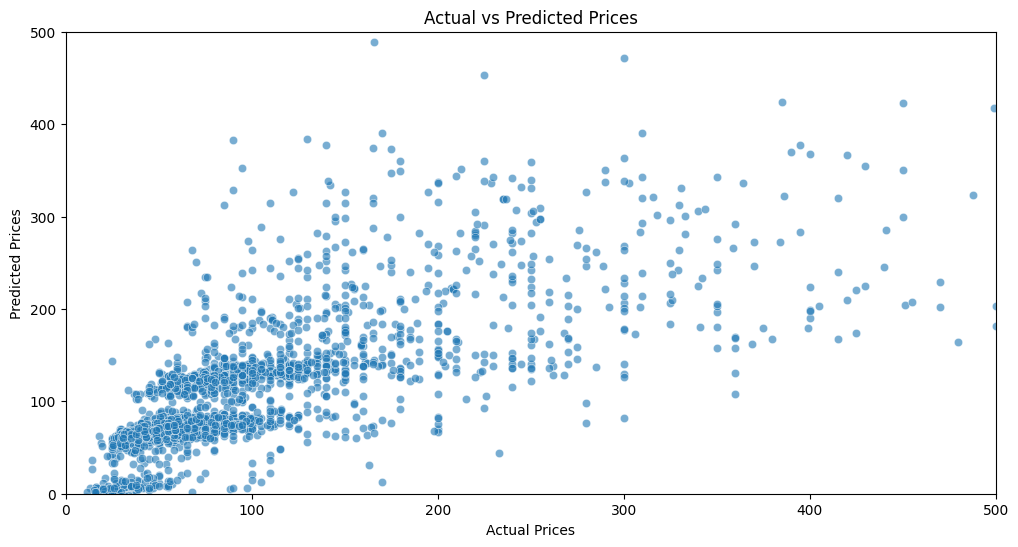

Actual Price: 80.0
Predicted Price for Sample Data: [75.94848287]


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/ISI/project/bengaluru_house_prices.csv'
df = pd.read_csv(file_path)

# Handle missing values
df.dropna(subset=['location', 'size', 'total_sqft', 'bath', 'price'], inplace=True)
df['balcony'] = df['balcony'].fillna(df['balcony'].median())

# Extract BHK from 'size' column
df['BHK'] = df['size'].str.extract('(\d+)').astype(float)
df.drop(columns=['size'], inplace=True)

# Convert 'total_sqft' to numerical by handling range values
def convert_sqft_to_num(sqft):
    try:
        tokens = str(sqft).split('-')
        return (float(tokens[0]) + float(tokens[1])) / 2 if len(tokens) == 2 else float(sqft)
    except ValueError:
        return np.nan  # Return NaN if conversion fails

df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
df.dropna(subset=['total_sqft'], inplace=True)

# Feature Engineering: Price per Sqft
df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']

# Drop less relevant features based on correlation
numeric_df = df.select_dtypes(include=[np.number])  # Select only numeric columns
correlation_matrix = numeric_df.corr()
correlation_threshold = 0.1  # Adjust as needed
low_correlation_features = correlation_matrix['price'][abs(correlation_matrix['price']) < correlation_threshold].index.tolist()
df.drop(columns=low_correlation_features, inplace=True)

# Encoding categorical feature
df = pd.get_dummies(df, columns=['location'], drop_first=True)

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Train-test split
from sklearn.model_selection import train_test_split
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure X_train contains only numeric values
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Train a simple Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Square root of MSE
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

# Confusion Matrix-like plot for regression
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()


# Test with a sample data point
sample_actual_price = y_test.iloc[0]
sample_data = X_test.iloc[0:1]
predicted_price = model.predict(sample_data)
print(f"Actual Price: {sample_actual_price}")
print(f"Predicted Price for Sample Data: {predicted_price}")
